In [ ]:
import os
import pandas as pd
import shutil
import random
import zipfile
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

## Data Preparation

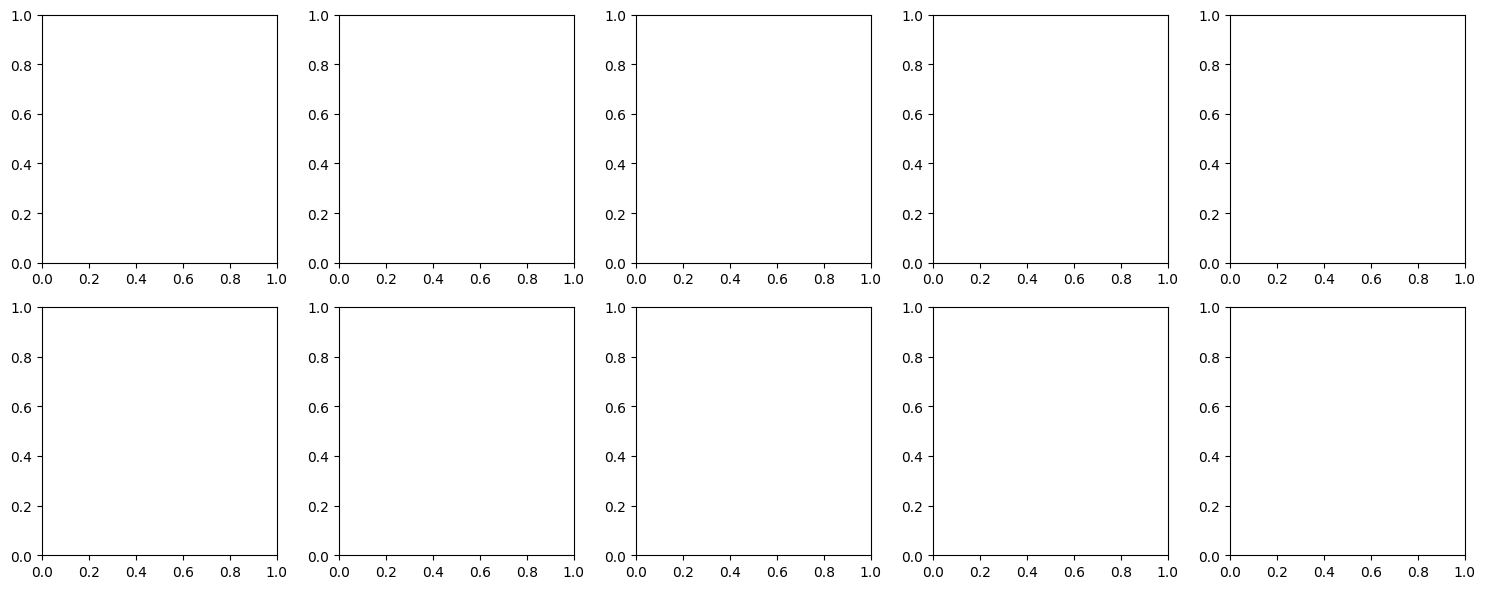

In [4]:
dataset_path = "BISINDO_Dataset/bisindo"
class_names = os.listdir(dataset_path)

fig, axs = plt.subplots(len(class_names), 5, figsize=(15, 3 * len(class_names)))

for i, class_name in enumerate(class_names):
    class_path = os.path.join(dataset_path, class_name)
    
    if not os.path.isdir(class_path):
        continue  # Skip if not a directory

    # Get only image files
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for j, image_name in enumerate(images[:5]):  # Show up to 5 images
        img_path = os.path.join(class_path, image_name)
        img = Image.open(img_path).convert("RGB")
        axs[i, j].imshow(img)
        axs[i, j].set_xlabel(class_name if j == 0 else "")
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

plt.tight_layout()
plt.show()


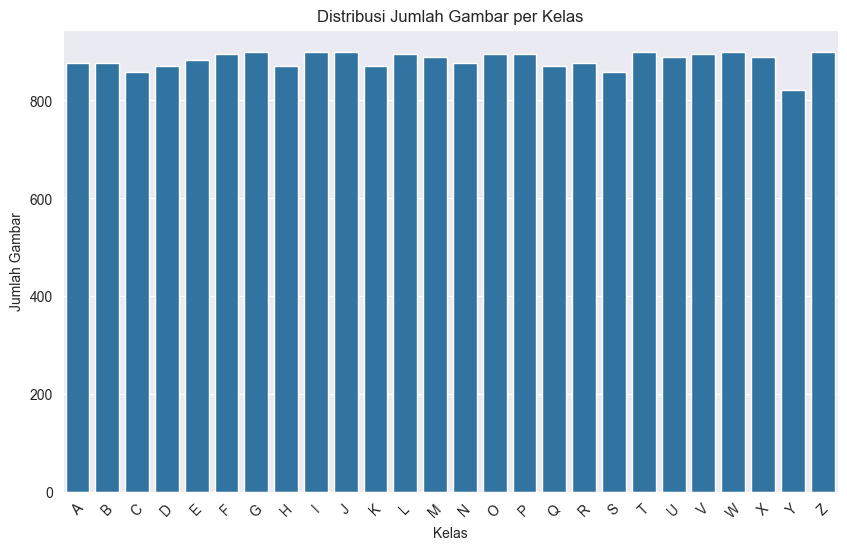

In [5]:
# List untuk simpan nama file, path lengkap, dan label kelas
file_name = []
labels = []
full_path = []

# Kumpulkan data
for path, subdirs, files in os.walk(dataset_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(os.path.basename(path))
        file_name.append(name)

# Buat DataFrame
distribution_df = pd.DataFrame({
    "path": full_path,
    "file_name": file_name,
    "labels": labels
})

# Plot distribusi jumlah gambar per kelas
plt.figure(figsize=(10,6))
sns.set_style("darkgrid")
sns.countplot(data=distribution_df, x='labels', order=sorted(distribution_df['labels'].unique()))
plt.title('Distribusi Jumlah Gambar per Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=45)
plt.show()


In [6]:
import numpy as np
import tensorflow as tf
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ------------------------------
# 1. Set Seed for Reproducibility
# ------------------------------
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# ------------------------------
# 2. Define Paths
# ------------------------------
TRAIN_DIR = '/content/bisindo_final/train'
VALID_DIR = '/content/bisindo_final/valid'
TEST_DIR = '/content/bisindo_final/test'

# ------------------------------
# 3. Data Augmentation
# ------------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest',
    horizontal_flip=False  # ubah ke True hanya jika arah tangan tidak penting
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# ------------------------------
# 4. Data Generators
# ------------------------------
BATCH_SIZE = 32
IMG_SIZE = (150, 150)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

validation_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size=IMG_SIZE,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    color_mode='rgb',
    batch_size=1,  # tetap 1 jika ingin evaluasi/prediksi urut per gambar
    class_mode='categorical',
    shuffle=False
)

# ------------------------------
# 5. Cek Konsistensi Kelas
# ------------------------------
assert train_generator.class_indices == validation_generator.class_indices == test_generator.class_indices, \
    "❌ Class indices tidak konsisten antara train, valid, dan test! Pastikan semua folder punya subfolder kelas yang sama."

print("✅ Data generators siap digunakan.")


Found 7340 images belonging to 26 classes.
Found 1836 images belonging to 26 classes.
Found 2294 images belonging to 26 classes.
✅ Data generators siap digunakan.


## Architektur

In [23]:
# Ukuran input gambar
input_shape = (150, 150, 3)

# Load base MobileNetV2 (tanpa top) - pretrained ImageNet
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
base_model.trainable = False  # Bekukan bobot pretrained

# model Sequential
model = Sequential([
    base_model,
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(26, activation='softmax')  # 5 kelas rumah adat
])

# Compile model
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Ringkasan model
model.summary()

C:\Users\asus\AppData\Local\Temp\ipykernel_17092\1714340953.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 5, 5, 32)       │       368,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 2, 2, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 26)             │         1,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,651,002 (10.11 MB)

 Trainable params: 393,018 (1.50 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [24]:
# Custom Callback
class StopAtAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, target_acc=0.98):
        super(StopAtAccuracy, self).__init__()
        self.target_acc = target_acc

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= self.target_acc:
            print(f"\nTraining dihentikan karena akurasi telah mencapai {logs.get('accuracy'):.2f}")
            self.model.stop_training = True

# Callbacks untuk optimasi training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
stop_at_acc = StopAtAccuracy(target_acc=0.98)

In [26]:
# Melakukan training
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True), StopAtAccuracy()]
)

Epoch 1/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 286s 1s/step - accuracy: 0.6628 - loss: 1.1130 - precision_3: 0.8868 - recall_3: 0.5494 - val_accuracy: 0.7647 - val_loss: 0.7988 - val_precision_3: 0.9415 - val_recall_3: 0.6923
Epoch 2/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 205s 891ms/step - accuracy: 0.6985 - loss: 0.9927 - precision_3: 0.8914 - recall_3: 0.6018 - val_accuracy: 0.7881 - val_loss: 0.6922 - val_precision_3: 0.9504 - val_recall_3: 0.7304
Epoch 3/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 147s 638ms/step - accuracy: 0.7271 - loss: 0.8889 - precision_3: 0.9051 - recall_3: 0.6413 - val_accuracy: 0.7854 - val_loss: 0.6851 - val_precision_3: 0.9396 - val_recall_3: 0.7293
Epoch 4/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 151s 656ms/step - accuracy: 0.7494 - loss: 0.8304 - precision_3: 0.9058 - recall_3: 0.6608 - val_accuracy: 0.8056 - val_loss: 0.6426 - val_precision_3: 0.9537 - val_recall_3: 0.7413
Epoch 5/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 209s 910ms/step - accuracy: 0.7584 - loss: 0.7843 - precision_3: 0.9130 - r

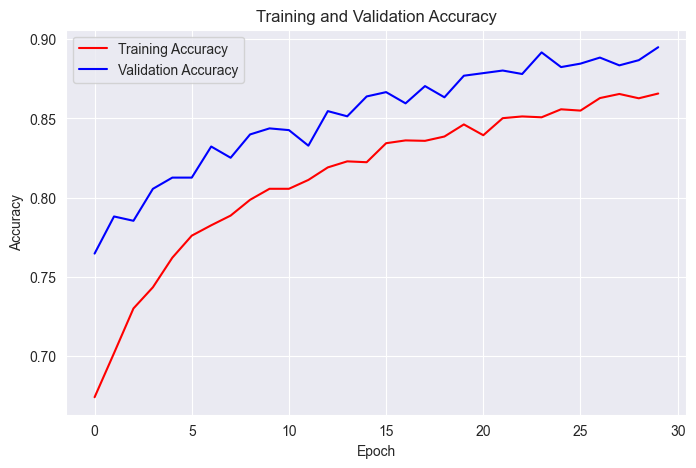

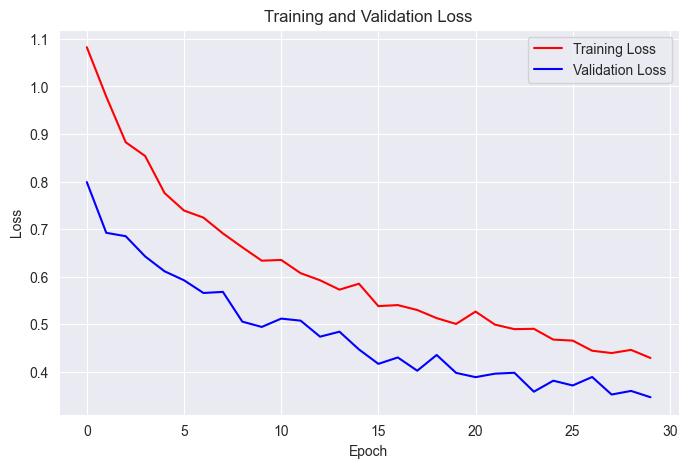

In [27]:
import matplotlib.pyplot as plt

# Ambil data dari history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
